<a href="https://colab.research.google.com/github/eorland/LSTM-Multistep-Prediction/blob/master/enc_dec_w_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#everything we will import to use later
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta
from matplotlib import pyplot as plt
from tensorflow.keras.models import model_from_json
import tensorflow_addons as tfa
from functions import rescale_no_pp, rescale_w_pp, lstm_prep_no_pp, lstm_prep_w_pp, rectify_cnn_data, mse_nan, mae_nan, evaluate_forecasts, threshold_rmse_eval, naive_forecast, add_max_rainfall, OrdinalToDatetime, predict

%matplotlib inline

import tensorflow.compat.v1 as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tqdm
from tqdm.keras import TqdmCallback
# import logging
# tf.get_logger().setLevel(logging.ERROR)
#check our version
# print(tf.VERSION)
# print(tf.keras.__version__)

In [3]:
forecast_hrs = 72
#pit_forecast = str(forecast_hrs)+"_1"
ocr = pd.read_csv('./sitka_data/processed_for_training_3_hour_72_no_vwc.csv', index_col=0)
#ocr = pd.read_csv('./SP1_processed.csv', index_col=0)
pp_cols = [v for v in ocr.columns if "Pressure_" in v]  # measures number of features for pp
VWC_cols = [v for v in ocr.columns if "vwc_" in v]  # measures number of features for VWC

num_targets = len(pp_cols)# + len(VWC_cols)
ocr.index = pd.to_datetime(ocr.index)

In [4]:
# scale data, no antecedant pp
data = ocr
data_scaling_features = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(data.iloc[:,:-num_targets])
data_scaled_df = pd.DataFrame(data_scaling_features.transform(data.iloc[:,:-num_targets]), index=ocr.index)
data_scaling_targets = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(data.iloc[:,-num_targets:])
data_scaled_df = pd.concat([data_scaled_df, (pd.DataFrame(data_scaling_targets.transform(data.iloc[:,-num_targets:]), index=ocr.index))], axis = 1)
data_scaled_df.fillna(-1, inplace=True)

ntrain = 56  #how long should the antecedant window be?
ntarg = 8  #this is the second and third variable, just good to keep them the same to cover all available data

# finally, prepare features and targets
features, targets, target_indices = lstm_prep_no_pp(data_scaled_df.index.values, data_scaled_df.values[:,:-num_targets], 
                                              data_scaled_df.values[:,-num_targets:], num_targets, ntrain, ntarg)

# create bounds for the prediction intervals
intervals = np.zeros(len(target_indices))
for i in range(0, len(intervals), targets.shape[1]):
    intervals[i]=1

intervals[intervals==0] = np.nan

binary_indices = np.copy(target_indices)

for i in range(0, len(binary_indices), forecast_hrs):
    binary_indices[i] = np.datetime64("NaT")
    
# set -1s to nan to be ignored
targets[targets==-1] = np.nan

100%|███████████████████████████████████████| 7433/7433 [06:09<00:00, 20.12it/s]


In [5]:
# # scale data, w/ antecedant pp
# data = ocr
# data_scaling = preprocessing.MinMaxScaler(feature_range=(0,1)).fit(data.iloc[:,:])
# data_scaled = pd.DataFrame(data_scaling.transform(data.iloc[:,:]),index=ocr.index)
# data_scaled_df = data_scaled.fillna(-1)

# # finally, prepare features and targets
# features, targets, target_indices = lstm_prep_w_pp(data_scaled_df.index.values, data_scaled_df.values, num_targets, forecast_hrs, forecast_hrs)

# # create bounds for the prediction intervals
# intervals = np.zeros(len(target_indices))
# for i in range(0,len(intervals),targets.shape[1]):
#     intervals[i]=1

# intervals[intervals==0] = np.nan

# binary_indices = np.copy(target_indices)

# for i in range(0,len(binary_indices),36):
#     binary_indices[i]=np.datetime64("NaT")
    
# # set -1s to nan to be ignored
# targets[targets==-1] = np.nan

In [6]:
# np.ceil(ocr.index.get_loc("2020-06-09 22:00:00")/36)
print(features.shape)

(7433, 56, 58)


In [7]:
# # BAD

# # split training/testing data. 0.7 split is about 2 water years of training data
# index_usgs_gap_start = ocr.index.get_loc("2020-06-09 22:00:00")
# split = 0.7
# pp_index = np.floor(index_usgs_gap_start/forecast_hrs)
# train_features = features[-int(pp_index*split):]
# test_features = features[-int(pp_index*(1-split)):]
# predict_features = features[:int(pp_index+1)]  #use these predict array when backcasting

# train_targets = targets[-int(pp_index*split):]
# test_targets = targets[-int(pp_index*(1-split)):]
# test_indices = target_indices[-test_targets.shape[0]*test_targets.shape[1]:]
# predict_targets = targets[:int(pp_index+1)]
# predict_indices = target_indices[:predict_targets.shape[0]*predict_targets.shape[1]]

In [8]:
# # KNIFE RIDGE

# # split training/testing data. 0.7 split is about 2 water years of training data

# split = 0.75

# train_features = features[:int((len(features)*split))]
# test_features = features[int((len(features)*split)):]

# train_targets = targets[:int((len(features)*split))]
# test_targets = targets[int((len(features)*split)):]
# test_indices = target_indices[-test_targets.shape[0]*test_targets.shape[1]:]

In [9]:
# GOOD?

# split training/testing data.
index_usgs_gap_start = ocr.index.get_loc("2020-06-09 21:00:00")
split = 0.7
pp_index = int(np.ceil(index_usgs_gap_start/ntarg))

train_split_index = int(features.shape[0]-pp_index)
test_split_index = int(train_split_index*(1-split))

train_features = features[pp_index:-test_split_index]
test_features = features[-test_split_index:]
predict_features = features[:int(pp_index+1)]  #use these predict array when backcasting

train_targets = targets[pp_index:-test_split_index]
test_targets = targets[-test_split_index:]
test_indices = target_indices[-test_targets.shape[0]*test_targets.shape[1]:]
predict_targets = targets[:int(pp_index+1)]
predict_indices = target_indices[:predict_targets.shape[0]*predict_targets.shape[1]]

In [10]:
print(train_features.shape)
print(test_features.shape)
print(predict_features.shape)
print(train_targets.shape)
print(test_targets.shape)
print(predict_targets.shape)

(705, 56, 58)
(302, 56, 58)
(6427, 56, 58)
(705, 8, 3)
(302, 8, 3)
(6427, 8, 3)


Create our Encoder:

In [11]:
# The below model is inspired by and adapted from: https://github.com/LukeTonin/keras-seq-2-seq-signal-prediction
# Define an input shape. This is the tensor shape our model expects from now on.
# This is essential for a stateful model
batch = None
#n_units = 36
n_units = forecast_hrs
#n_units = features.shape[2]

encoder_inputs = Input(batch_input_shape=(batch, train_features.shape[1], train_features.shape[2]), name="encoder_input")

encoder_lstm = LSTM(n_units, return_state=True, stateful=False, return_sequences=True, name="encoder") # define encoder
# connect encoding layer to our inputs, return all states

encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

Create Decoder:

In [12]:
# Define inputs to the decoder.
decoder_inputs = Input(batch_input_shape=(batch, None, train_targets.shape[2]), name="decoder_input")

# Create Decoder...
decoder_lstm = LSTM(n_units, return_state=True, return_sequences=True, stateful=False, name="decoder")

# Important step: connect Decoder to our input layers and use the hidden and cell states 
# from the encoder to instantiate this layer
#decoder_outputs, decoder_h, decoder_c = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])
decoder_outputs, decoder_h, decoder_c = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_states = [decoder_h, decoder_c]

#create attention layer
# ----------------------
attention = dot([decoder_outputs, encoder_outputs], axes=[2, 2], name="attention_dot")
attention2 = Activation('softmax')(attention)

context = dot([attention2, encoder_outputs], axes=[2,1], name="context_dot")
decoder_combined_context = concatenate([context, decoder_outputs])

# ----------------------

decoder_dense1 = Dense(50, activation='tanh', name="decoder_dense1")
dense_context = decoder_dense1(decoder_combined_context)

dropout = Dropout(0.5)
drop = dropout(dense_context)

decoder_dense2 = Dense(train_targets.shape[2], activation='linear', name="decoder_context")
decoder_outputs = decoder_dense2(drop)

In [13]:
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.compile(optimizer='adam', loss=mse_nan, metrics=mse_nan)

In [14]:
#model.summary()

In [20]:
# initialize tqdm callback with default parameters
tqdm_callback = tfa.callbacks.TQDMProgressBar()

# if a computer can fit every epoch in one go, set epochs to 1 (or any lower number) and encase the fit command in a for loop.
# successive calls to the fit command will increasingly fit the model
model.fit([train_features, train_features[:,-8:,-num_targets:]], train_targets, epochs=2000, batch_size=80, verbose=0, shuffle=False, callbacks=[TqdmCallback(verbose=0)])
#model.fit([train_features, train_features[:,-ntarg:,-num_targets:]], train_targets, epochs=2000, batch_size=forecast_hrs, verbose=0, shuffle=False, callbacks=[TqdmCallback(verbose=0)])
print("Fitting complete! ")

0epoch [00:00, ?epoch/s]

Fitting complete! 


In [21]:
#define inference ('inf') model, a separate encoding model. This just outputs our encoder states
encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
inf_encoder_outputs, inf_encoder_states = encoder_model(encoder_inputs)

# set state shapes, which tells our decoder to accepts inputs states of the specificed size
decoder_states_inputs = [Input(shape=(n_units,)), Input(shape=(n_units,))]

# create our decoding layer. accepts same shape as decoder inputs and encoder states
inf_decoder_outputs, inf_state_h, inf_state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

# save decoder output states. We'll use these as the input states for our decoder for predicting each next timestep
# after the initial input of our encoder states
inf_decoder_states = [inf_state_h, inf_state_c]

inf_attention = dot([inf_decoder_outputs, inf_encoder_outputs], axes=[2, 2])
inf_attention2 = Activation('softmax')(inf_attention)

inf_context = dot([inf_attention2, inf_encoder_outputs], axes=[2,1])
inf_decoder_combined_context = concatenate([inf_context, inf_decoder_outputs])

inf_dense_context = decoder_dense1(inf_decoder_combined_context)
inf_drop = dropout(inf_dense_context)

inf_final_outputs = decoder_dense2(inf_drop)

# finally, instantiate our decoder model. Inputs are the original sequence + the encoder states. 
# outputs: sequence prediction + the states used for the decoder
decoder_model = Model([encoder_inputs, decoder_inputs]+decoder_states_inputs, [inf_final_outputs]+inf_decoder_states)

Evaluate Model

In [22]:
# # no antecedent pp
# predictions = predict(test_features, encoder_model, decoder_model, num_steps_to_predict=train_targets.shape[1],
#                       num_features_to_predict=train_targets.shape[2], batch_size=None)

# tests, preds = rescale_no_pp(test_features, test_targets, predictions, data_scaling_features, data_scaling_targets, test_indices)

test data new shape: (2416, 3)
prediction new shape: (2416, 3)


In [18]:
# # w antecedent pp
# predictions = predict(test_features, encoder_model, decoder_model, num_steps_to_predict=train_targets.shape[1],
#                       num_features_to_predict=train_targets.shape[2], batch_size=None)

# tests, preds = rescale_w_pp(test_features, test_targets, predictions, data_scaling, test_indices)

In [25]:
# backcast (w no antecedent pp)
predictions = predict(predict_features, encoder_model, decoder_model, num_steps_to_predict=train_targets.shape[1],
                      num_features_to_predict=train_targets.shape[2], batch_size=None)

tests_back, preds_back = rescale_no_pp(predict_features, predict_targets, predictions, data_scaling_features, data_scaling_targets, predict_indices)

test data new shape: (51416, 3)
prediction new shape: (51416, 3)


In [48]:
# score, scores = evaluate_forecasts(tests.values, preds.values)

# #generate naive predictions
# # naive_preds = naive_forecast(tests.values,1,24)
# # naive_preds = pd.DataFrame(naive_preds, index=tests.index)

# #evaluate model performance on RMSE of just hazardous pore pressure values
# print("\nLSTM Performance:")
# y_pos, pred_pos, rmse, diff_array = threshold_rmse_eval(tests.values, preds.values, -1.0)
# # print("Naive Comparison:")
# # y_pos_naive, naive_pos, naive_rmse, naive_diff_array = threshold_rmse_eval(tests.values, naive_preds.values, -0.5)

In [49]:
#print(preds.index[0], '\n', preds.index[-1])

In [26]:
ocr.index = ocr.index.tz_localize(None)
preds_back

,0,1,2
2002-11-13 06:00:00,0.290690,0.292087,-0.000074
2002-11-13 09:00:00,0.292565,0.301853,0.000884
2002-11-13 12:00:00,0.294115,0.312957,0.002040
2002-11-13 15:00:00,0.296929,0.314731,0.001908
2002-11-13 18:00:00,0.295869,0.313217,0.001856
...,...,...,...
2020-06-17 15:00:00,0.245641,0.249414,0.000213
2020-06-17 18:00:00,0.245435,0.249271,0.000222
2020-06-17 21:00:00,0.245948,0.249934,0.000238
2020-06-18 00:00:00,0.253269,0.259369,0.000470


In [19]:
#preds_back

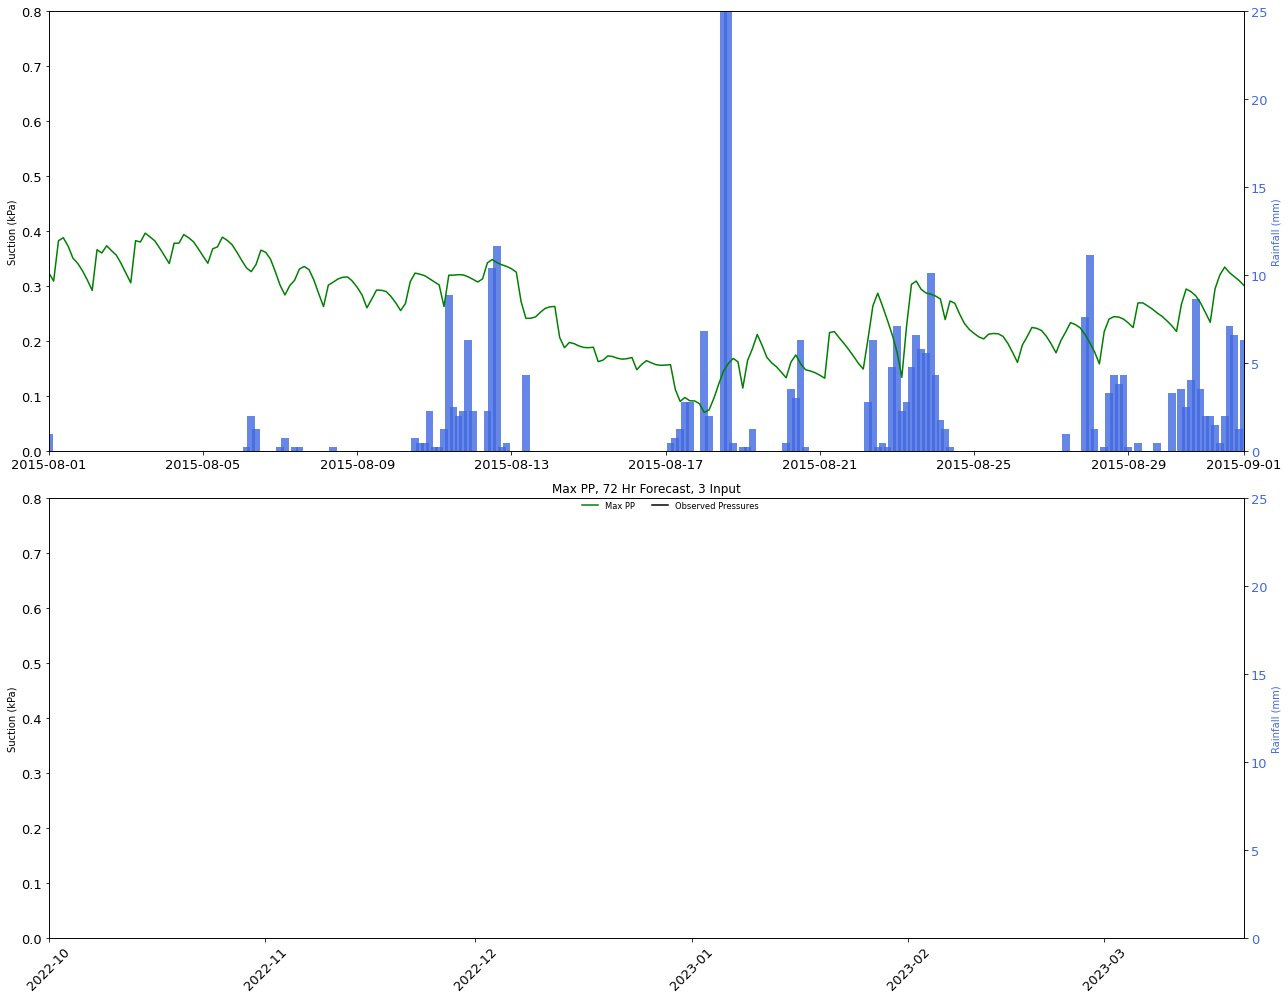

In [29]:
import matplotlib.lines as mlines

start_1 = pd.to_datetime('2015-08-01')
end_1 = pd.to_datetime('2015-09-01')

# start_1 = pd.to_datetime('2022-05-30')
# end_1 = pd.to_datetime('2022-10-01')

# start_3 = pd.to_datetime('2022-10-01')
# end_3 = pd.to_datetime('2023-03-21')

#messy plot of rainfall and test data/predictions. I've been messing with the y axis range to help clean it up

#col_list = VWC_cols + pp_cols
col_list = pp_cols

fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(18,14), sharex=False)

# ax1.scatter(tests.index, tests.iloc[:, 1], c='k', linewidth=1, label='Observed Data')
# ax1.scatter(preds.index, preds.iloc[:, 1], c='green', label='Predictions_1')

ax1.plot(tests_back.iloc[:, 1], c='k', linewidth=1, label='Observed Data')
ax1.plot(preds_back.iloc[:, 1], c='green', label='Predictions_1')

# ax3.plot(tests.iloc[:, 1], c='k', linewidth=1, label='Observed Data')
# ax3.plot(preds.iloc[:, 1], c='green', label='Predictions_1')

#ax1.scatter(target_indices, intervals, c='k', marker='|', s=50, alpha=0.5)

ax1.set_xlim(start_1, end_1)
ax3.set_xlim(start_3, end_3)  

ax1.set_ylabel('Suction (kPa)')
ax1.set_ylim(0.0, 0.8)
ax1.xaxis.set_visible(True)

ax3.set_ylabel('Suction (kPa)')
ax3.set_ylim(0.0, 0.8)
ax3.xaxis.set_visible(True)

plt.xticks(rotation=45)

ax1.tick_params(axis='both', labelcolor='k', labelsize=13)
ax3.tick_params(axis='both', labelcolor='k', labelsize=13)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis

ax1.patch.set_visible(False)
ax1.set_zorder(ax2.get_zorder() + 1)

ax3.patch.set_visible(False)
ax3.set_zorder(ax4.get_zorder() + 1)

ax2.set_ylabel('Rainfall (mm)', color='royalblue')  # we already handled the x-label with ax1
ax2.bar(preds_back.index, ocr.loc[preds_back.index, ocr.columns[0]], color='royalblue', alpha=0.8,width=0.2)
ax2.tick_params(axis='y', labelcolor='royalblue', labelsize=13)

ax2.set_ylim(0,25)

ax4.set_ylabel('Rainfall (mm)', color='royalblue')  # we already handled the x-label with ax1
ax4.bar(preds_back.index, ocr.loc[preds_back.index, ocr.columns[0]], color='royalblue', alpha=0.8,width=0.2)
ax4.tick_params(axis='y', labelcolor='royalblue', labelsize=13)

ax4.set_ylim(0,25)

one_line = mlines.Line2D([], [], color='green', marker='',
                  markersize=15, label='Max PP')
# two_line = mlines.Line2D([], [], color='blue', marker='',
#                   markersize=15, label='2 Hour')


black_line = mlines.Line2D([], [], color='k', marker='',
                  markersize=15, label='Observed Pressures')

plt.legend(handles=[one_line, black_line], loc='upper center',
        fontsize='small', bbox_to_anchor=(0.52,1.01), ncol=4,
        markerscale=1.3, frameon=False)
# plt.legend(handles=[one_line_hr, one_line_ft, black_line], loc='upper center',
#         fontsize='small', bbox_to_anchor=(0.52,1.01), ncol=4,
#         markerscale=1.3, frameon=False)

plt.title("Max PP, 72 Hr Forecast, 3 Input")

plt.setp(ax1.get_xticklabels(True, "major"), visible=True)
plt.setp(ax3.get_xticklabels(True, "major"), visible=True)


plt.tight_layout()

#plt.savefig('./sitka_data/training_figs/'+str(forecast_hrs)+'_combined_1_hrs_fts.png',dpi=300)
plt.show()

In [ ]:
# r_values_full = np.zeros((7,len(col_list)))
# pits_index = 0

In [20]:
preds.to_csv('./sitka_data/prediction_results/prediction_test_hard_split_batch_100.csv')

ValueError: Input contains NaN.

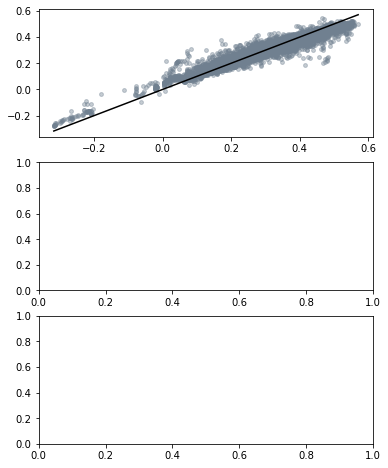

In [23]:
from sklearn.metrics import r2_score
from scipy.stats import linregress

col_list = pp_cols
fig, ax = plt.subplots(3, 1, figsize=(6,8), sharex=False)
i = 1
for col in col_list:
    while i < (len(col_list)+1):
        x = np.linspace(np.nanmin(tests.iloc[:,i-1]), np.nanmax(tests.iloc[:,i-1]),100)
        y = x
        ax1 = ax[i-1]
        ax1.plot(x, y, c='k')
        ax1.scatter(tests.iloc[:,i-1], preds.iloc[:,i-1], c='slategrey', s=15, alpha=0.4)
      
        r2 = r2_score(tests.iloc[:,i-1], preds.iloc[:,i-1])
        print(linregress(tests.iloc[:,i-1], preds.iloc[:,i-1]))
        slope, intercept, r_value, p_value, std_err = linregress(tests.iloc[:,i-1],
                                                               preds.iloc[:,i-1])
        print(slope)
        ax1.annotate(('R = '+'{0:.3f}'.format((r_value))),(0.75,0.2),None,'axes fraction')
        #r_values_full[pits_index, i-1] = r_value
        #ax1.annotate(('Slope = '+'{0:.3f}'.format((slope))),(0.10,0.72),None,'axes fraction')
        #if i == 1:
            #ax1.set_title('Soil Matric Potential - Observed vs. Predicted Comparison')
        ax1.set_ylabel('Predicted (kPa)')
        ax1.set_xlabel('Observed Value (kPa)')

        i = i+1
    
#pits_index += 1

plt.tight_layout()
#plt.savefig('36hr_36_24_d75dr50_cor_plot_SMALLER.svg',dpi=300)

In [ ]:
r_values_full